# Predicting tsunami casualties
*By Antoine Payan and Gaëlle Guillou*

## Introduction

### Our objective

Tsunamis are an upcoming scientific challenge in their anticipation and the development of efficient solutions, as global warming hikes risk of landslide tsunamis. Predicting them is not an easy endeavour, and we shall leave that to others, but trying to anticipate their impact could have be of strong interest for insurance companies and governments.

We based our work on a Kaggle Dataset from NOAA, *Tsunami Causes and Waves, Cause, magnitude, and intensity of every tsunami since 2000 BC*.

**Can we predict the occurence of Tsunamis, in terms of date, location?**

**If not, can we at least anticipate the human and physical damages for a given wave, seism?**

### Some information about tsunamis

Anything that rapidly displaces a large volume of water can cause a tsunami. Typically, tsunamis are caused by underwater earthquakes, but landslides, volcanic eruptions, calving icebergs, and (very rarely) meteorite impacts can also generate tsunamis. These types of events can cause large disturbances in the surface of the ocean, and when gravity pulls the water back down, the tsunami is born.

"Tsunami" comes from the Japanese words for harbor ("tsu") and wave ("nami").

### Can tsunamis be predicted?

Since earthquakes cannot be predicted, we do not know when a tsunami will happen before the earthquake occurs. Once a large potentially tsunamigenic earthquake does occur, we can forecast tsunami arrival times and wave heights through the use of computer modeling.

[https://ptwc.weather.gov/faq.php#1]


### Outline of the project


1. **EDA and Visualisation**
2. **Missing Values Study**
3. **Feature Engineering**
4. **Looking into Tsunami Fatalities**
5. **Predicting Fatalities**

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set(rc={'figure.figsize':(20,10)})

import math


from mpl_toolkits.basemap import Basemap

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import mean_squared_error, make_scorer

import xgboost as xgb

## 1. Exploratory Data Analysis and Visualisation

In [2]:
waves = pd.read_csv('data/waves.csv')
sources = pd.read_csv('data/sources.csv')

### Waves data

In [3]:
waves.head()

,SOURCE_ID,WAVE_ID,YEAR,MONTH,DAY,REGION_CODE,COUNTRY,STATE/PROVINCE,LOCATION,LATITUDE,...,INJURIES,INJURY_ESTIMATE,FATALITIES,FATALITY_ESTIMATE,DAMAGE_MILLIONS_DOLLARS,DAMAGE_ESTIMATE,HOUSES_DAMAGED,HOUSE_DAMAGE_ESTIMATE,HOUSES_DESTROYED,HOUSE_DESTRUCTION_ESTIMATE
0,1,11014,-2000,NaN,NaN,50.0,SYRIA,NaN,UGARIT,35.583,...,NaN,NaN,NaN,3.0,NaN,4.0,NaN,NaN,NaN,NaN
1,3,17601,-1610,NaN,NaN,50.0,SYRIA,NaN,UGARIT,35.583,...,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN
2,3,1,-1610,NaN,NaN,50.0,GREECE,NaN,N. AND E. COAST CRETE,35.500,...,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN
3,9,2,-479,NaN,NaN,50.0,GREECE,NaN,"POTIDAEA, MACEDONIA",40.300,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,10,19364,-426,6.0,NaN,50.0,GREECE,NaN,TARFI,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
waves.describe()

,SOURCE_ID,WAVE_ID,YEAR,MONTH,DAY,REGION_CODE,LATITUDE,LONGITUDE,DISTANCE_FROM_SOURCE,TRAVEL_TIME_HOURS,...,INJURIES,INJURY_ESTIMATE,FATALITIES,FATALITY_ESTIMATE,DAMAGE_MILLIONS_DOLLARS,DAMAGE_ESTIMATE,HOUSES_DAMAGED,HOUSE_DAMAGE_ESTIMATE,HOUSES_DESTROYED,HOUSE_DESTRUCTION_ESTIMATE
count,26203.000000,26203.000000,26203.000000,26099.000000,25990.000000,26202.000000,25591.000000,25591.000000,25320.000000,3272.000000,...,123.000000,129.000000,683.000000,904.000000,135.000000,1887.000000,162.000000,402.000000,292.000000,758.000000
mean,3146.880434,16701.682937,1959.461207,6.133990,15.326048,80.779330,21.819451,50.248786,2463.739573,6.596577,...,131.260163,1.550388,1258.500732,1.829646,1714.728926,1.424483,522.012346,1.868159,1874.808219,1.799472
std,1718.398292,8999.325433,135.750038,3.504212,8.519406,9.637029,24.936755,121.136966,4217.066399,7.198404,...,407.925436,0.856603,13460.721455,1.035240,18931.934914,0.757777,3070.279840,2.176737,16486.712040,0.939040
min,1.000000,1.000000,-2000.000000,1.000000,1.000000,30.000000,-77.850000,-179.876000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.001000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,1884.000000,9393.500000,1952.000000,3.000000,11.000000,81.000000,5.480500,-73.158000,112.000000,1.000000,...,2.000000,1.000000,3.000000,1.000000,0.050000,1.000000,10.000000,1.000000,4.000000,1.000000
50%,2406.000000,16986.000000,1996.000000,5.000000,12.000000,85.000000,34.500000,133.250000,255.000000,4.000000,...,12.000000,1.000000,18.000000,1.000000,0.500000,1.000000,38.500000,1.000000,24.000000,1.000000
75%,5413.000000,23998.500000,2011.000000,9.000000,23.000000,85.000000,39.034970,141.500000,3439.750000,11.000000,...,68.000000,2.000000,133.000000,3.000000,9.750000,2.000000,266.750000,3.000000,151.250000,3.000000
max,5642.000000,32418.000000,2017.000000,12.000000,31.000000,89.000000,70.250000,179.367000,19331.000000,47.000000,...,2943.000000,4.000000,300000.000000,4.000000,220000.000000,4.000000,38561.000000,33.000000,235377.000000,4.000000


### Sources data

In [5]:
sources.head()

,SOURCE_ID,YEAR,MONTH,DAY,HOUR,MINUTE,CAUSE,VALIDITY,FOCAL_DEPTH,PRIMARY_MAGNITUDE,...,ALL_INJURIES,INJURY_TOTAL,ALL_FATALITIES,FATALITY_TOTAL,ALL_DAMAGE_MILLIONS,DAMAGE_TOTAL,ALL_HOUSES_DAMAGED,HOUSE_DAMAGE_TOTAL,ALL_HOUSES_DESTROYED,HOUSE_DESTRUCTION_TOTAL
0,1,-2000,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,4.0,NaN,NaN,NaN,NaN
1,3,-1610,NaN,NaN,NaN,NaN,6.0,4.0,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN
2,4,-1365,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
3,5,-1300,NaN,NaN,NaN,NaN,0.0,2.0,NaN,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,-760,NaN,NaN,NaN,NaN,0.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
sources.describe()

,SOURCE_ID,YEAR,MONTH,DAY,HOUR,MINUTE,CAUSE,VALIDITY,FOCAL_DEPTH,PRIMARY_MAGNITUDE,...,ALL_INJURIES,INJURY_TOTAL,ALL_FATALITIES,FATALITY_TOTAL,ALL_DAMAGE_MILLIONS,DAMAGE_TOTAL,ALL_HOUSES_DAMAGED,HOUSE_DAMAGE_TOTAL,ALL_HOUSES_DESTROYED,HOUSE_DESTRUCTION_TOTAL
count,2582.000000,2582.000000,2443.000000,2341.000000,1319.000000,1233.000000,2576.000000,2580.000000,867.000000,1459.000000,...,223.000000,263.000000,522.000000,653.000000,116.000000,1006.000000,52.000000,145.000000,2.060000e+02,575.000000
mean,2132.966692,1805.891944,6.621367,15.618539,11.319939,28.225466,1.786879,2.334109,36.205306,7.038725,...,5334.354260,2.304183,4380.680077,2.229709,4805.086534,2.186879,29188.826923,2.268966,3.794183e+04,2.690435
std,1546.994278,350.752703,3.486535,8.680274,6.929352,17.202228,2.260681,1.558476,37.163354,0.803739,...,32961.882201,1.125122,20610.548682,1.214397,24019.330461,1.046609,86723.543401,1.094527,3.767096e+05,0.999039
min,1.000000,-2000.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,3.200000,...,1.000000,1.000000,1.000000,1.000000,0.003000,1.000000,2.000000,1.000000,1.000000e+00,1.000000
25%,940.250000,1818.000000,4.000000,8.000000,5.000000,14.000000,1.000000,1.000000,19.000000,6.600000,...,19.500000,1.000000,7.000000,1.000000,1.780750,1.000000,119.250000,1.000000,7.075000e+01,2.000000
50%,1797.500000,1895.000000,7.000000,16.000000,11.000000,29.000000,1.000000,2.000000,33.000000,7.000000,...,100.000000,3.000000,56.000000,2.000000,30.000000,2.000000,820.000000,2.000000,7.000000e+02,3.000000
75%,3148.750000,1956.000000,10.000000,23.000000,17.000000,43.000000,1.000000,4.000000,40.000000,7.600000,...,511.000000,3.000000,1001.000000,3.000000,500.000000,3.000000,6851.500000,3.000000,3.000000e+03,3.000000
max,5642.000000,2017.000000,12.000000,31.000000,23.000000,59.000000,11.000000,4.000000,600.000000,9.500000,...,374171.000000,4.000000,316000.000000,4.000000,220085.456000,4.000000,500000.000000,4.000000,5.360000e+06,4.000000


### Tsunamis all over the world

In [7]:
def show_tsunami_map():
    plt.figure(figsize=(20, 12))

    map = Basemap(lat_0=0, lon_0=0)

    map.drawmapboundary(fill_color='lightblue')
    map.fillcontinents(color='green', lake_color='lightblue')
    map.drawcoastlines()

    lons_w = waves.LONGITUDE.tolist()
    lats_w = waves.LATITUDE.tolist()

    lons_s = sources.LONGITUDE.tolist()
    lats_s = sources.LATITUDE.tolist()

    xw, yw = map(lons_w, lats_w)
    xs, ys = map(lons_s, lats_s)

    map.scatter(xw, yw, marker='D', color='R', s=[math.sqrt(h) * 20 if h else 0 for h in waves.MAXIMUM_HEIGHT], 
                label='Tsunamis')
    map.scatter(xs, ys, marker='D', color='B', s=[m * 3 if m else 0 for m in sources.PRIMARY_MAGNITUDE],
                label='Seisms')
    plt.legend()
    plt.show()

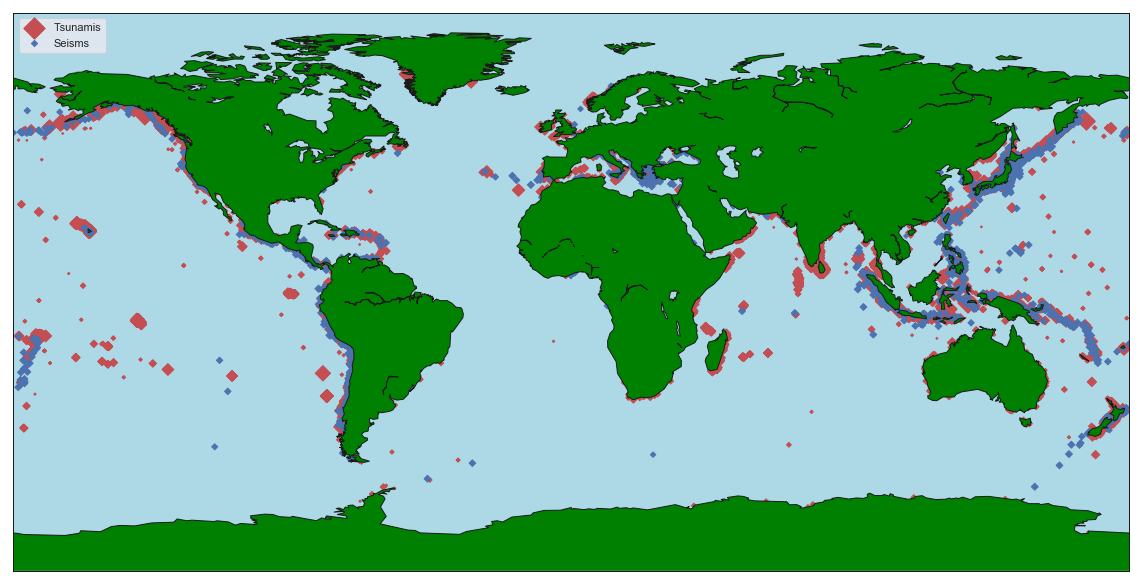

In [8]:
show_tsunami_map()

Waves (in red) and sources (in blue) of the tsunamis, with size relative to their height / magnitude. The tecnonic plaques subtly appear in this map.

### Looking into tsunamis historically

In short: the number of tsunamis **on record** has known an exponential growth over the last decade.

In [9]:
def show_tsunami_evolution():
    sns.set_style("whitegrid")

    ax = sns.lineplot(
        x="YEAR",
        y="WAVE_ID",
        data=waves[waves.YEAR > 1850].groupby("YEAR").count()
        ["WAVE_ID"].reset_index()
    )
    
    ax.set(xlabel='Year', ylabel='Wave count')
    plt.show()

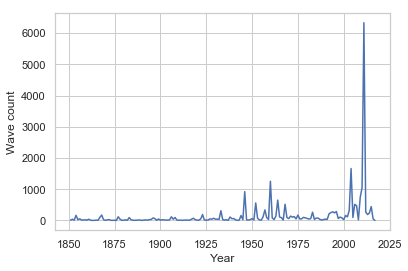

In [10]:
show_tsunami_evolution()

In [11]:
def show_monthly_repartition():
    sns.set_style("whitegrid")

    ax = sns.barplot(
        x="MONTH",
        y="WAVE_ID",
        data=waves.groupby("MONTH").count()['WAVE_ID'].reset_index()
    )

    ax.set(xlabel='Month', ylabel='Wave count')
    plt.show()

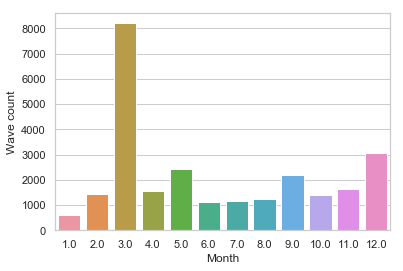

In [12]:
show_monthly_repartition()

Though there is no clear trend of seasonality (since most tsunamis are caused by earthquakes, and earthquakes are not subject to seasons), it is quite obvious that some months have had a much larger share of tsunami waves (at least in our data), namely March, May, and December.

### Exploring geographical patterns

In [13]:
def plot_wave_count(cat="COUNTRY", n=10, sort=True, log=True):

    sns.set_style("whitegrid")

    data_grouped = waves.groupby(cat).count()['WAVE_ID'].reset_index()

    data_grouped[cat] = data_grouped[cat].astype(str)

    if sort:
        data_grouped = data_grouped.sort_values("WAVE_ID", ascending=False)

    if n is not None:
        data_grouped = data_grouped.head(n)

    ax = sns.barplot(
        x=cat,
        y="WAVE_ID",
        data=data_grouped)

    ax.set(
        xlabel=cat.capitalize(),
        ylabel='Wave count',
        title='Wave count by ' + cat.capitalize())

    if log:
        ax.set(yscale="log")

    plt.show()

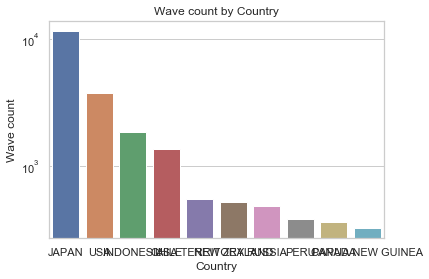

In [14]:
plot_wave_count("COUNTRY", log = True)

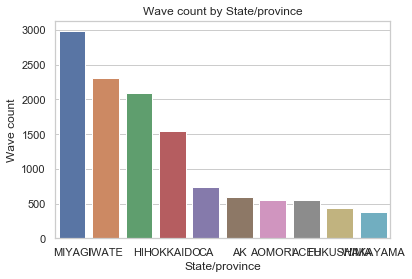

In [15]:
plot_wave_count("STATE/PROVINCE", log = False)

As one could expect, some regions are much more susceptible to experience tsunamis: Japan mainly, the USA, and Indonesia.

### Exploring relationships between variables

In [16]:
def show_correlation_heatmap():
    C = waves.drop(['SOURCE_ID', 'WAVE_ID', 'LATITUDE', 'LONGITUDE'], 1).corr()

    cutoff_corr = 0.3

    mask = np.zeros_like(C, dtype=np.bool)
    mask[(C < cutoff_corr) & (C > -cutoff_corr)] = True
    mask[np.triu_indices_from(mask)] = True

    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(data=C, xticklabels=C.columns, yticklabels=C.columns, mask=mask, cmap=cmap)
    plt.show()

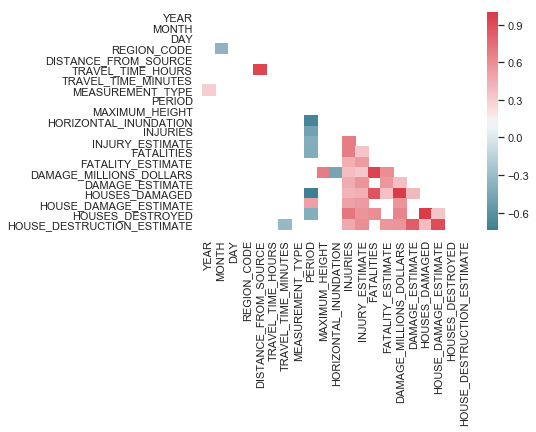

In [17]:
# Correlation only appears if |c| > 0.3
show_correlation_heatmap()

As we can see, even with a fair cutoff value (0.3), most correlations are between the injuries, damages and houses, which makes a lot of sense. It means we will have trouble figuring out how to predict damages and fatalities from this quantitative data only, but that it should be easier to fill in missing values.

In [18]:
def show_fatalities_height_relationship():
    f, ax = plt.subplots(figsize=(20, 10))

    ax.set(xscale="log", yscale="log")

    sns.regplot(
        x="MAXIMUM_HEIGHT",
        y="FATALITIES",
        data=waves,
        ax=ax,
        scatter_kws={"s": 100})
    plt.show()

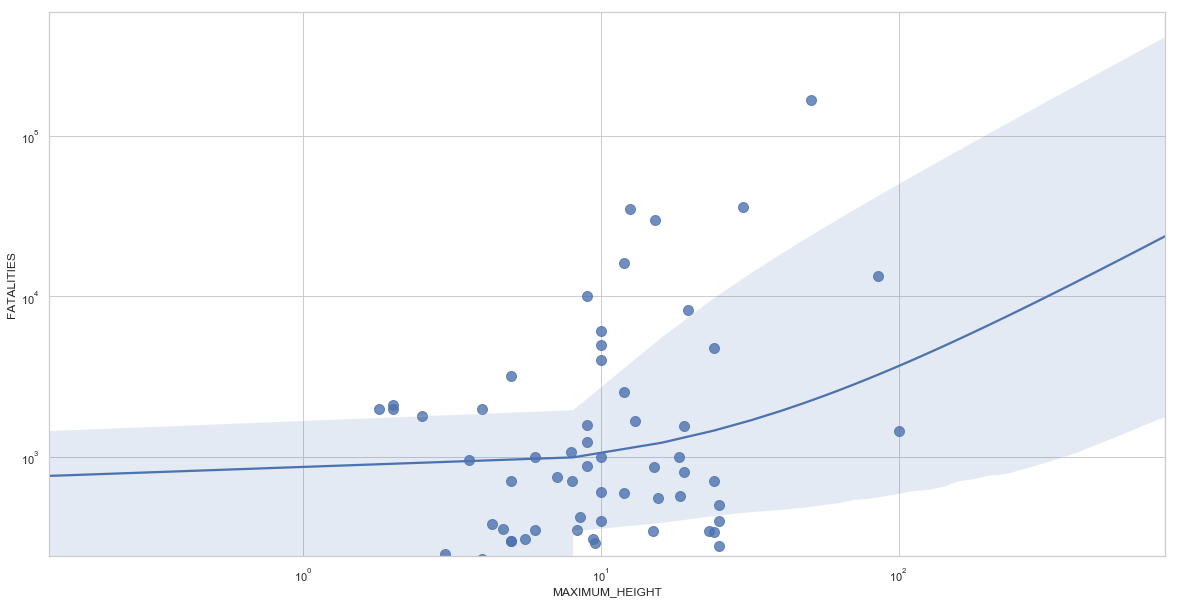

In [19]:
show_fatalities_height_relationship()

The relationship between height and fatalities is perhaps not what you would expect: the positive linear relationship barely exists for extreme values.

## 2. Missing Values Study

Let's see where are our missing values more prevalent so that we can build a consistent dataset for predicting Tsunami casualties.

In [20]:
waves.count().sort_values(ascending=True).head(10)

INJURIES                      123
INJURY_ESTIMATE               129
DAMAGE_MILLIONS_DOLLARS       135
HOUSES_DAMAGED                162
HOUSES_DESTROYED              292
VALIDITY                      327
HOUSE_DAMAGE_ESTIMATE         402
FATALITIES                    683
HOUSE_DESTRUCTION_ESTIMATE    758
FATALITY_ESTIMATE             904
dtype: int64

In [21]:
def split_interest_drop_columns(keeping=['FATAL', 'MISSING']):
    matchers = ['INJUR', 'FATAL', 'DAMAGE', 'HOUSE', 'MISSING']

    matchers = [m for m in matchers if m not in keeping]

    return [col for col in waves_sources.columns if \
            any(matcher in col for matcher in keeping)], \
           [col for col in waves_sources.columns if \
            any(matcher in col for matcher in matchers) and col not in keeping]

In [22]:
waves_sources = pd.merge(
                        waves, 
                        sources, 
                        how='left', 
                        on='SOURCE_ID', 
                        suffixes=('_wave', '_source'))

consequences_col = split_interest_drop_columns('')[1]

# First filter
waves_sources = waves_sources.dropna(subset=consequences_col, how='all')

## 3. Feature Engineering

In order to obtain more accuracy on predictions, we will merge the GDP (Gross Domestic Product) and the Population density to the original dataset.

In [23]:
def find_by_country_per_year(df, country, year):
    if str(year) not in df.columns:
        return np.nan
    try:
        return df.loc[country, str(year)]
    except:
        return np.nan
    
# The datasets obtained are merged thanks to the country name, some differ
renamings = {
    'UNITED STATES': 'USA'
}

### Adding GDP index according to the country and the year 

In [24]:
gdp = pd.read_csv(
    'data/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10475113.csv',
    header=2,
    index_col=0)

gdp.index = pd.Series(gdp.index).apply(lambda x: x.upper())

gdp.rename(renamings, inplace=True)

waves_sources['GDP'] = waves_sources \
    .apply(lambda x: find_by_country_per_year(gdp, x.COUNTRY_wave, x.YEAR_wave), axis=1)

### Adding Population density (people per sq. km of land area)

In [25]:
dens = pd.read_csv('data/API_EN.POP.DNST_DS2_en_csv_v2_10474044.csv', header=2, index_col=0)

dens.index = pd.Series(dens.index).apply(lambda x: x.upper())

dens.rename(renamings, inplace=True)

waves_sources['DENSITY'] = waves_sources \
    .apply(lambda x: find_by_country_per_year(dens, x.COUNTRY_wave, x.YEAR_wave), axis=1)

## 4. Looking into Tsunami Fatalities

### Choosing the right value from our different data sources

In [26]:
def fill_values_by_other_variables(df, correspondances={}):
    for key, value in correspondances.items():
        df[key].fillna(df[value], inplace=True)
        
def bidirectional_fill_values(df, correspondances={}):
    fill_values_by_other_variables(df, correspondances=correspondances)
    fill_values_by_other_variables(df, correspondances={value:key for key,value in correspondances.items()})

In [27]:
correspondances = {
    'INJURIES_wave': 'INJURY_ESTIMATE_wave',
    'INJURIES_source': 'INJURY_ESTIMATE_source',
    'FATALITIES_wave': 'FATALITY_ESTIMATE_wave',
    'DAMAGE_MILLIONS_DOLLARS_wave': 'DAMAGE_ESTIMATE_wave',
    'HOUSES_DAMAGED_wave': 'HOUSE_DAMAGE_ESTIMATE_wave',
    'HOUSES_DESTROYED_wave': 'HOUSE_DESTRUCTION_ESTIMATE_wave',
    'MISSING': 'MISSING_ESTIMATE',
    'FATALITIES_source': 'FATALITY_ESTIMATE_source',
    'DAMAGE_MILLIONS_DOLLARS_source': 'DAMAGE_ESTIMATE_source',
    'HOUSES_DAMAGED_source': 'HOUSE_DAMAGE_ESTIMATE_source',
    'HOUSES_DESTROYED_source': 'HOUSE_DESTRUCTION_ESTIMATE_source',
}

fill_values_by_other_variables(waves_sources, correspondances=correspondances)

waves_sources = waves_sources.drop(correspondances.values(),axis=1)

In [28]:
fatalities_columns, to_drop_columns = split_interest_drop_columns(
    keeping=['FATALITIES_wave'])

fatalities_columns.sort()

tsunami_fatalities = waves_sources \
    .dropna(subset=fatalities_columns, how='all') \
    .drop(to_drop_columns, axis=1)

tsunami_fatalities.sort_values(by='FATALITIES_wave', ascending=False).head(5)

,SOURCE_ID,WAVE_ID,YEAR_wave,MONTH_wave,DAY_wave,REGION_CODE_wave,COUNTRY_wave,STATE/PROVINCE_wave,LOCATION_wave,LATITUDE_wave,...,LOCATION_source,LATITUDE_source,LONGITUDE_source,MAXIMUM_HEIGHT_source,MAGNITUDE_ABE,MAGNITUDE_IIDA,INTENSITY_SOLOVIEV,WARNING_STATUS,GDP,DENSITY
699,2691,315,1737,10.0,11.0,60.0,INDIA,WEST BENGAL,HOOGLY RIVER,NaN,...,CALCUTTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14415,2439,9370,2004,12.0,26.0,60.0,INDONESIA,NaN,ALL OF INDONESIA,NaN,...,OFF W. COAST OF SUMATRA,3.316,95.854,50.9,NaN,NaN,NaN,4.0,2.568369e+11,123.436935
2516,1142,1339,1883,8.0,27.0,60.0,INDONESIA,NaN,SUNDA STRAIT,-6.0,...,KRAKATAU,-6.102,105.423,41.0,NaN,5.1,4.0,NaN,NaN,NaN
14332,2439,9375,2004,12.0,26.0,60.0,SRI LANKA,NaN,ALL OF SRI LANKA,NaN,...,OFF W. COAST OF SUMATRA,3.316,95.854,50.9,NaN,NaN,NaN,4.0,2.066253e+10,308.922628
778,456,31961,1755,11.0,1.0,73.0,PORTUGAL,NaN,ALL OF PORTUGAL,NaN,...,LISBON,37.000,-10.000,18.3,NaN,3.6,NaN,NaN,NaN,NaN


### Handling outliers and NAs

1. Deleting outliers, corresponding to extremely rare natural disasters
2. Deleting columns with only NA values

In [29]:
tsunami_fatalities = tsunami_fatalities[~tsunami_fatalities.WAVE_ID.isin([315, 9370])]
    
tsunami_fatalities.dropna(axis=1, how='all', inplace=True)

travel_time = []
for i, row in tsunami_fatalities.iterrows():
    time = 0.0
    if not np.isnan(row.TRAVEL_TIME_HOURS):
        time += row.TRAVEL_TIME_HOURS
    if not np.isnan(row.TRAVEL_TIME_MINUTES):
        time += row.TRAVEL_TIME_MINUTES / 60
    travel_time.append(time if time > 0 else np.nan)
    
tsunami_fatalities['TRAVEL_TIME'] = travel_time

tsunami_fatalities.fillna({'WARNING_STATUS': -1}, inplace=True)

In [30]:
to_drop_columns = [
    'WAVE_ID',
    'LATITUDE_wave',
    'LONGITUDE_wave',
    'LATITUDE_source',
    'LONGITUDE_source',
    'COUNTRY_source', 
    'STATE/PROVINCE_source',
    'LOCATION_source',
    'REGION_CODE_source',
    'SOURCE_ID',
    'YEAR_source',
    'MONTH_source',
    'DAY_source',
    'TRAVEL_TIME_HOURS',
    'TRAVEL_TIME_MINUTES',
    'PERIOD',
    'FIRST_MOTION',
    'VALIDITY_wave'
]

tsunami_fatalities.drop(to_drop_columns, axis=1, inplace=True)

In [31]:
column_types = tsunami_fatalities.dtypes

cat_cols = column_types[column_types == 'object'].index.values

# Copy for a later different handling of categorical columns:

tsunami_fatalities_mte = tsunami_fatalities.copy()

# Factorize categorical columns:

for cat in cat_cols:
    tsunami_fatalities.loc[:, cat] = pd.factorize(tsunami_fatalities.loc[:, cat])[0]
    
tsunami_fatalities.fillna(-1, axis=1, inplace=True)

The response variable is highly skewed, we will apply a log-transformation in order to make it more gaussian. Then, we will filter outliers corresponding to rare events. We have too little data points to be able to predict such natural disasters. 

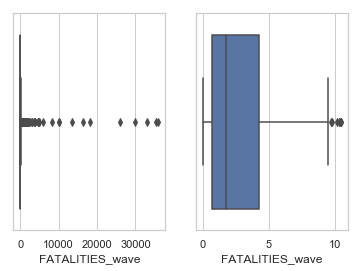

In [32]:
# Removing rows with no FATALITIES records
tsunami_fatalities = tsunami_fatalities[tsunami_fatalities.FATALITIES_wave > 0]

# Plotting the response variable: normal vs. log
fig, axs = plt.subplots(ncols=2)
sns.boxplot(tsunami_fatalities.FATALITIES_wave, ax=axs[0])
sns.boxplot(np.log(tsunami_fatalities.FATALITIES_wave), ax=axs[1])

# Transforming the response variable
tsunami_fatalities.loc[:, 'FATALITIES_wave'] = tsunami_fatalities.FATALITIES_wave.apply(np.log)

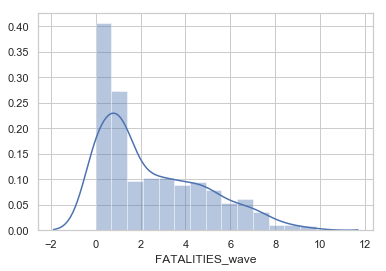

Mean : 258.8428093645485
Standard-Deviation : 1211.7524770617604


In [33]:
# Removing outliers
tsunami_fatalities = tsunami_fatalities[tsunami_fatalities.FATALITIES_wave < 10]

# Plotting final repartition of response variable
sns.distplot(tsunami_fatalities.FATALITIES_wave)
plt.show()

print('Mean : %s' % np.exp(tsunami_fatalities.FATALITIES_wave).mean())
print('Standard-Deviation : %s' % np.exp(tsunami_fatalities.FATALITIES_wave).std())

As we can see here, the standard deviation is very wide. This will for sure cause problems in the granularity of our prediction.

## 5. Predicting Fatalities

We will perform multiple model trainings to predict the number of casualties :
1. Linear Regression
2. Lasso Regression
3. XGBoost Linear

### Train / test split

In [34]:
n_splits = 5
target_col = 'FATALITIES_wave'

predictors = tsunami_fatalities.drop(target_col, axis=1)
response = tsunami_fatalities.FATALITIES_wave

X_train, X_test, y_train, y_test = train_test_split(predictors, response, random_state=12)

### Linear regression

In [35]:
# Linear Regression

reg = LinearRegression()

grid = GridSearchCV(
    estimator=reg,
    param_grid={'fit_intercept':[True, False]},
    cv=ShuffleSplit(n_splits=n_splits),
    scoring=make_scorer(mean_squared_error)
)

grid.fit(X_train, y_train)

print(grid.best_params_)

print("RMSE Train : %s" % np.sqrt(mean_squared_error(np.exp(grid.predict(X_train)), np.exp(y_train))))
print("RMSE Test : %s" % np.sqrt(mean_squared_error(np.exp(grid.predict(X_test)), np.exp(y_test))))

{'fit_intercept': True}
RMSE Train : 1136.0652502131547
RMSE Test : 1482.5446363541557


### Lasso regression

In [36]:
# Lasso Regression

params = {
    'alpha': [10, 15, 20, 30, 40],
    'fit_intercept':[True, False]
}

reg = Lasso()

grid = GridSearchCV(
    estimator=reg,
    param_grid=params,
    cv=ShuffleSplit(n_splits=n_splits),
    scoring=make_scorer(mean_squared_error)
)

grid.fit(X_train, y_train)

print(grid.best_params_)


print("RMSE Train : %s" % np.sqrt(mean_squared_error(np.exp(grid.predict(X_train)), np.exp(y_train))))
print("RMSE Test : %s" % np.sqrt(mean_squared_error(np.exp(grid.predict(X_test)), np.exp(y_test))))

{'alpha': 30, 'fit_intercept': False}
RMSE Train : 1140.6514658624212
RMSE Test : 1484.6472209116355


### XGBoost

In [37]:
# XGBoost

num_rounds = 10000
early_stop = 500
verbose_eval = 200

kfold = ShuffleSplit(n_splits=n_splits, random_state=2121)

params = {
    'eta': 0.005,
    'colsample_bytree': 0.8,
    'subsample': 0.85,
    'reg_lambda': 0.05
}

oof_train = np.zeros((X_train.shape[0]))
oof_test = np.zeros((X_test.shape[0], n_splits))


i = 0
for train_index, valid_index in kfold.split(X_train, y_train):
    
    X_tr, y_tr = X_train.iloc[train_index, :], y_train.iloc[train_index]
    X_val, y_val = X_train.iloc[valid_index, :], y_train.iloc[valid_index]
    
    d_train = xgb.DMatrix(X_tr, label=y_tr)
    d_valid = xgb.DMatrix(X_val, label=y_val)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    
    print('Training XGB:')
    model = xgb.train(params,
                      dtrain=d_train,
                      num_boost_round=num_rounds,
                      evals=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)
    
    val_pred = model.predict(xgb.DMatrix(X_val), ntree_limit=model.best_ntree_limit)
    test_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
    
    oof_train[valid_index] = val_pred
    oof_test[:, i] = test_pred
    
    i += 1

print('RMSE Train : %s' % np.sqrt(mean_squared_error(np.exp(oof_train), np.exp(y_train))))
print('RMSE Test : %s' % np.sqrt(mean_squared_error(np.exp(oof_test.mean(axis=1)), np.exp(y_test))))

Training XGB:
[0]	train-rmse:3.0004	valid-rmse:2.61459
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	train-rmse:1.73828	valid-rmse:1.78896
[400]	train-rmse:1.27552	valid-rmse:1.669
[600]	train-rmse:1.0603	valid-rmse:1.6693
[800]	train-rmse:0.929802	valid-rmse:1.68317
Stopping. Best iteration:
[474]	train-rmse:1.17737	valid-rmse:1.66234

Training XGB:
[0]	train-rmse:2.92771	valid-rmse:3.26855
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[200]	train-rmse:1.68375	valid-rmse:2.28129
[400]	train-rmse:1.24157	valid-rmse:2.11087
[600]	train-rmse:1.03916	valid-rmse:2.09374
[800]	train-rmse:0.911767	valid-rmse:2.10328
[1000]	train-rmse:0.81215	valid-rmse:2.11011
Stopping. Best iteration:
[622]	train-rmse:1.02277	valid-rmse:2.09274

Training XGB:
[0]	train-rmse:2.94067	valid-rmse:3.15887
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[200]	train-rmse:1.68841	valid-rmse:2.28625
[400]	train-rms

### Result analysis

In [38]:
train_xgb_residuals = y_train - oof_train
train_lasso_residuals = y_train - grid.predict(X_train)

def show_residuals():
    x = [i for i in range(1, train_lasso_residuals.shape[0] + 1)]

    sns.scatterplot(x, train_xgb_residuals, label='XGBoost')
    sns.scatterplot(x, train_lasso_residuals, label='Lasso')
    plt.axhline(0, color='red')
    plt.title('Residuals')
    plt.show()

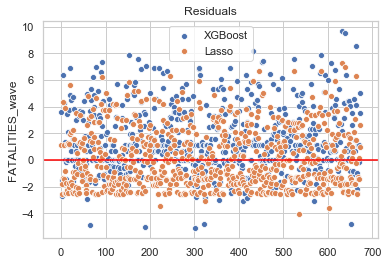

In [39]:
show_residuals()

In [40]:
import scipy.stats as stats

def show_qqplot():
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax1 = stats.probplot(train_xgb_residuals, dist=stats.norm, plot=ax)
    ax2 = stats.probplot(train_lasso_residuals, dist=stats.norm, plot=ax)

    ax.get_lines()[1].set_color('c')
    ax.get_lines()[2].set_color('orange')

    plt.legend(['XGBoost', 'Normal XGB', 'Lasso', 'Normal Lasso'])
    plt.show()

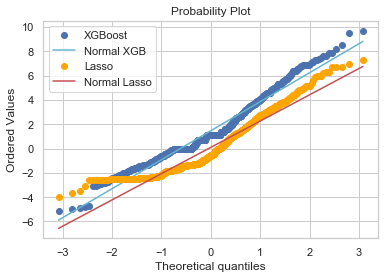

In [41]:
show_qqplot()

Our three models are not performing well on our fatalities response, especially on extreme values.


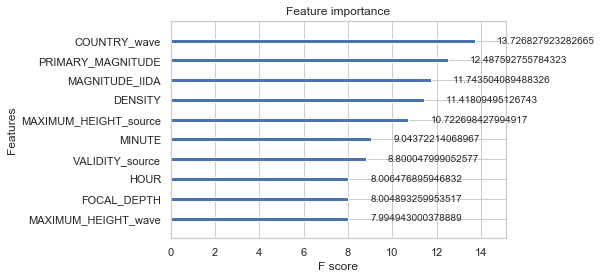

In [42]:
xgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.show()

We can notice some facts about the feature importance, computed according to the average gain of splits which use the feature : 
1. `density` variable is making a high gain in average, meaning our feature engineering part has been useful
2. Both Magnitude metrics seem to make a difference when splitting samples
3. `MAXIMUM_HEIGHT_source`, corresponding to the maximum height of the wave caused by the seism seems to be related 

### Changing our categorical value encoding

Since we have a large number of categorical variables, we will try to use them through mean target value encoding. We copied earlier before handling categorical value the tsunami_fatalities dataset into tsunami_fatalities_mte.

In [43]:
# Data Cleaning: starting with tsunami_fatalities_mte which was a copy of tsunami_fatalities

# Mean Target Encoding:
for cat in cat_cols:
    
    # Groupby and get the mean, transform as a dictionary
    
    gb_dict = tsunami_fatalities_mte.loc[:, [cat, target_col
                                         ]].groupby(cat).mean(
                                         ).to_dict()[target_col]

    # Map the categorical columns with their mean values
    
    tsunami_fatalities_mte.loc[:, cat] = tsunami_fatalities_mte.loc[:, cat].map(gb_dict)

# Repeat Steps:
    
tsunami_fatalities_mte.fillna(-1, axis=1, inplace=True)

tsunami_fatalities_mte = tsunami_fatalities_mte[tsunami_fatalities_mte.FATALITIES_wave > 0]

tsunami_fatalities_mte.loc[:, 'FATALITIES_wave'] = tsunami_fatalities_mte.FATALITIES_wave.apply(np.log)

tsunami_fatalities_mte = tsunami_fatalities_mte[tsunami_fatalities_mte.FATALITIES_wave < 10]

We now implement our models with our new categorical value imputing.

In [44]:
predictors = tsunami_fatalities_mte.drop(target_col, axis=1)
response = tsunami_fatalities_mte.FATALITIES_wave

X_train, X_test, y_train, y_test = train_test_split(predictors, response, random_state=12)

In [45]:
# XGBoost

num_rounds = 10000
early_stop = 500
verbose_eval = 200

kfold = ShuffleSplit(n_splits=n_splits, random_state=2121)

params = {
    'eta': 0.005,
    'colsample_bytree': 0.8,
    'subsample': 0.85,
    'reg_lambda': 0.05
}

oof_train = np.zeros((X_train.shape[0]))
oof_test = np.zeros((X_test.shape[0], n_splits))


i = 0
for train_index, valid_index in kfold.split(X_train, y_train):
    
    X_tr, y_tr = X_train.iloc[train_index, :], y_train.iloc[train_index]
    X_val, y_val = X_train.iloc[valid_index, :], y_train.iloc[valid_index]
    
    d_train = xgb.DMatrix(X_tr, label=y_tr)
    d_valid = xgb.DMatrix(X_val, label=y_val)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    
    print('Training XGB:')
    model = xgb.train(params,
                      dtrain=d_train,
                      num_boost_round=num_rounds,
                      evals=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)
    
    val_pred = model.predict(xgb.DMatrix(X_val), ntree_limit=model.best_ntree_limit)
    test_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
    
    oof_train[valid_index] = val_pred
    oof_test[:, i] = test_pred
    
    i += 1

print('RMSE Train : %s' % np.sqrt(mean_squared_error(np.exp(oof_train), np.exp(y_train))))
print('RMSE Test : %s' % np.sqrt(mean_squared_error(np.exp(oof_test.mean(axis=1)), np.exp(y_test))))

Training XGB:
[0]	train-rmse:2.99628	valid-rmse:2.61024
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	train-rmse:1.25516	valid-rmse:1.23793
[400]	train-rmse:0.596552	valid-rmse:0.943908
[600]	train-rmse:0.337181	valid-rmse:0.919349
[800]	train-rmse:0.220563	valid-rmse:0.923393
[1000]	train-rmse:0.162234	valid-rmse:0.926968
Stopping. Best iteration:
[625]	train-rmse:0.317077	valid-rmse:0.917435

Training XGB:
[0]	train-rmse:2.92336	valid-rmse:3.26339
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[200]	train-rmse:1.22508	valid-rmse:1.61681
[400]	train-rmse:0.581553	valid-rmse:1.1398
[600]	train-rmse:0.332827	valid-rmse:1.03381
[800]	train-rmse:0.221372	valid-rmse:1.00604
[1000]	train-rmse:0.164614	valid-rmse:0.998963
[1200]	train-rmse:0.127521	valid-rmse:0.997796
[1400]	train-rmse:0.103432	valid-rmse:0.996402
[1600]	train-rmse:0.084196	valid-rmse:0.997382
[1800]	train-rmse:0.069249	valid-rmse:0.997537
Stopping. Best iteration:
[1424]	train-rmse:0.100405	valid-rmse:0.996

Training XGB

In [46]:
train_xgb_residuals = y_train - oof_train

def plot_residuals_mte():
    fig = plt.figure()

    ax = fig.add_subplot(111)

    ax1 = stats.probplot(train_xgb_residuals, dist=stats.norm, plot=ax)

    ax.get_lines()[1].set_color('c')

    plt.legend(['XGBoost', 'Normal XGB'])
    plt.show()

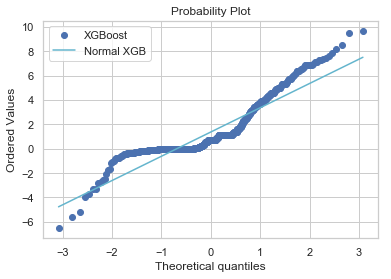

In [47]:
plot_residuals_mte()

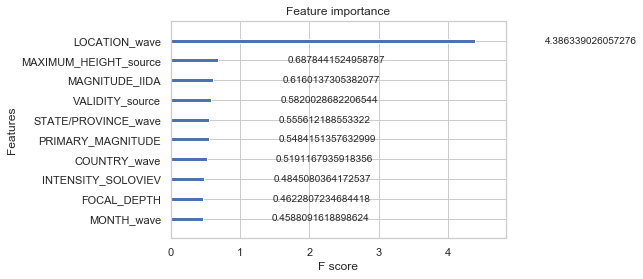

In [48]:
xgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.show()

We have lost the normal distribution of our residuals, but gained in precision. Our graph shows that location remains the most important predictor of the fatalities.

## Conclusion

We have explored the possibility of predicting tsunami casualties. After exploring our data and realizing there was little correlation, we explored the solution of feature engineering. We added the GDP index for each country and year, as well as the population density for each country. We then built our model especially with XGBoost, toying around with different categorical values encoding. Our final model gave us an RMSE of 1292 (though on a log-scale). 

We're bound to conclude that predicting fatalities from the little data that we have is complicated, though we have managed to improve our model. This could be of great help to insurance companies and governments for instance, even though a good level of precision is nearly impossible to attain.